In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gunapulokeswari","key":"0d0096918c94f6f1c1954770d4f63785"}'}

In [3]:
#create kaggle folder
! mkdir ~/.kaggle 

In [4]:
#copy json to folder created
! cp kaggle.json ~/.kaggle/

In [5]:
#permission for the json act
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d yasserhessein/gender-dataset

100% 1.31G/1.32G [00:09<00:00, 187MB/s]
100% 1.32G/1.32G [00:09<00:00, 143MB/s]


In [7]:
!kaggle datasets download -d yasserhessein/testmodel

  0% 0.00/60.3k [00:00<?, ?B/s]
100% 60.3k/60.3k [00:00<00:00, 41.7MB/s]


In [9]:
!unzip testmodel.zip

Archive:  testmodel.zip
  inflating: test1.jpg               
  inflating: test2.jpg               


In [8]:
#!unzip celeba-dataset.zip
!unzip gender-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Validation/Male/189674.jpg  
  inflating: Dataset/Validation/Male/189675.jpg  
  inflating: Dataset/Validation/Male/189676.jpg  
  inflating: Dataset/Validation/Male/189679.jpg  
  inflating: Dataset/Validation/Male/189681.jpg  
  inflating: Dataset/Validation/Male/189684.jpg  
  inflating: Dataset/Validation/Male/189688.jpg  
  inflating: Dataset/Validation/Male/189689.jpg  
  inflating: Dataset/Validation/Male/189691.jpg  
  inflating: Dataset/Validation/Male/189692.jpg  
  inflating: Dataset/Validation/Male/189693.jpg  
  inflating: Dataset/Validation/Male/189694.jpg  
  inflating: Dataset/Validation/Male/189695.jpg  
  inflating: Dataset/Validation/Male/189696.jpg  
  inflating: Dataset/Validation/Male/189697.jpg  
  inflating: Dataset/Validation/Male/189698.jpg  
  inflating: Dataset/Validation/Male/189702.jpg  
  inflating: Dataset/Validation/Male/189704.jpg  
  inflating: Dataset/Validation/Male/189705.jpg  

In [42]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from keras.layers import BatchNormalization
from keras.optimizers import Adam

In [43]:
train_datagen = ImageDataGenerator(rescale = 1./255,
      rotation_range=25,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [44]:
batch_size = 64
target_size = (64, 64)
input_shape=(64, 64, 3)
seed=1337
adam = 0.001
fre= -20
FC = 2048
E = 1
patience = 3
verbose = 1
factor = 0.50
min_lr = 0.0001
steps_per_epoch=256
validation_steps=256
epochs=8

In [45]:
test_datagen = ImageDataGenerator( rescale = 1.0/255)

train_generator = train_datagen.flow_from_directory('/content/Dataset/Train',
                                                    batch_size =batch_size ,
                                                    class_mode = 'binary',
                                                    seed=seed,
                                                    target_size = target_size )     

validation_generator =  test_datagen.flow_from_directory( '/content/Dataset/Validation',
                                                          batch_size  = batch_size,
                                                          class_mode  = 'binary',
                                                          seed=seed,
                                                          target_size = target_size)

Found 160000 images belonging to 2 classes.
Found 22598 images belonging to 2 classes.


In [46]:
base_model = tf.keras.applications.VGG16(input_shape=input_shape,include_top=False,weights="imagenet")

In [47]:
# Freezing Layers

for layer in base_model.layers[:fre]:
    layer.trainable=False

In [48]:
# Building Model
model=Sequential()
model.add(base_model)
model.add(layers.Dropout(.2))

model.add(Conv2D(512, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(128, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(384, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(384, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(500, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,strides=(2,2), padding='same'))



# Add new layers
model.add(Flatten())
model.add(Dense(FC , activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(FC , activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(FC, activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(E, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 dropout_8 (Dropout)         (None, 2, 2, 512)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 2, 512)         2359808   
                                                                 
 batch_normalization_5 (Batc  (None, 2, 2, 512)        2048      
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 2, 2, 512)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 2, 2, 128)         589952    
                                                      

In [49]:
model.compile(optimizer=Adam(adam),
              loss='binary_crossentropy'
              ,metrics=['accuracy'])

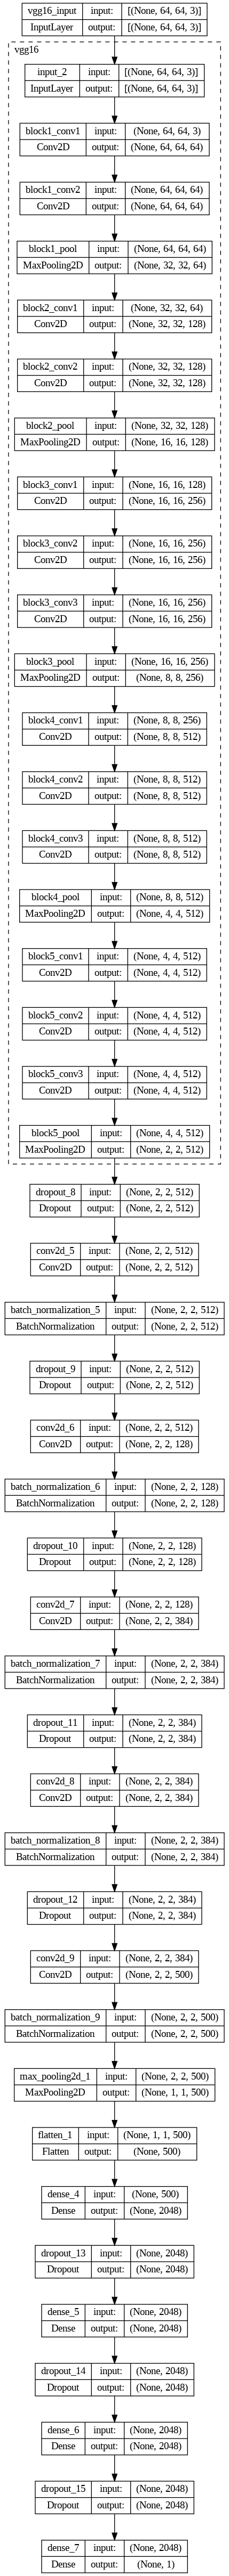

In [50]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [51]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',
                        patience = patience,
                        verbose = verbose ,
                        factor = factor,
                        min_lr = min_lr)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=verbose, patience=patience)

In [52]:
%time
hist = model.fit_generator(generator=train_generator,
                           validation_data=validation_generator,
                           steps_per_epoch=steps_per_epoch,
                           validation_steps=validation_steps,
                           epochs=epochs,
                           callbacks=[lrd, mcp, es])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


<ipython-input-52-3bc3d617dcc8>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(generator=train_generator,


Epoch 1/8
256/256 [==============================] - 80s 303ms/step - loss: 0.6767 - accuracy: 0.6562 - val_loss: 1.6111 - val_accuracy: 0.6785 - lr: 0.0010
Epoch 2/8
256/256 [==============================] - 77s 300ms/step - loss: 0.4990 - accuracy: 0.7621 - val_loss: 1.3062 - val_accuracy: 0.7183 - lr: 0.0010
Epoch 3/8
256/256 [==============================] - 75s 294ms/step - loss: 0.3245 - accuracy: 0.8644 - val_loss: 0.6669 - val_accuracy: 0.8301 - lr: 0.0010
Epoch 4/8
256/256 [==============================] - 73s 286ms/step - loss: 0.2507 - accuracy: 0.9003 - val_loss: 0.2029 - val_accuracy: 0.9199 - lr: 0.0010
Epoch 5/8
256/256 [==============================] - 73s 286ms/step - loss: 0.2168 - accuracy: 0.9131 - val_loss: 0.2178 - val_accuracy: 0.9252 - lr: 0.0010
Epoch 6/8
256/256 [==============================] - 71s 278ms/step - loss: 0.2023 - accuracy: 0.9229 - val_loss: 0.1854 - val_accuracy: 0.9314 - lr: 0.0010
Epoch 7/8
256/256 [==============================] - 70s 2

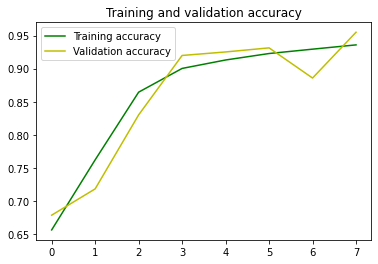

<Figure size 432x288 with 0 Axes>

In [53]:
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

accuracy: 0.9550